In [1]:
try:
    done
except:
    done = True
    !mkdir lenses
    !tar -xf /kaggle/input/ml4sci/lenses.tgz
    !pip install -q e2cnn

**Specific Test IV. Exploring Equivariant Neural Networks**

**Task:** Use an Equivariant Neural Network of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.


**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)


In [2]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from e2cnn import gspaces
from e2cnn import nn as e2nn
from itertools import cycle
from PIL import Image
from skimage import io, transform
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from torch import optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms, utils
from torchvision.transforms import (Compose, Pad, RandomRotation, Resize,
                                    ToTensor)

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
def get_train_valid_loader(
    data_dir,
    batch_size,
    random_seed,
    valid_size=0.1,
    shuffle=True,
):

    valid_transform = transforms.Compose(
        [
            transforms.RandomCrop(128),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )

    train_transform = transforms.Compose(
        [
            transforms.RandomRotation(30),
            transforms.RandomCrop(128),
            transforms.Resize(256),
            transforms.RandomRotation(180),
            transforms.ColorJitter(brightness=(0.8, 1.2)),
            transforms.Resize(128),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir,
        transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir,
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=2,
        pin_memory=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=2,
        pin_memory=True,
    )

    return (train_loader, valid_loader)

In [4]:
lr = 0.0001
epochs = 10
gamma = 0.7
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lense_train, lense_test = get_train_valid_loader('lenses', batch_size, 40, 0.1)

# Model

In [5]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=3):
        
        super(C8SteerableCNN, self).__init__()
        
        self.r2_act = gspaces.Rot2dOnR2(N=4)
        in_type = e2nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        self.input_type = in_type
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = e2nn.SequentialModule(
            e2nn.MaskModule(in_type, 128, margin=1),
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        in_type = self.block1.out_type
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        in_type = self.block2.out_type
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        in_type = self.block3.out_type
        out_type = e2nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        in_type = self.block4.out_type
        out_type = e2nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        in_type = self.block5.out_type
        out_type = e2nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = e2nn.GroupPooling(out_type)
        c = self.gpool.out_type.size
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(40000, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        x = e2nn.GeometricTensor(input, self.input_type)
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        x = self.pool3(x)
        
        x = self.gpool(x)

        x = x.tensor
        
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [6]:
model = C8SteerableCNN(2).to(device)

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)

# Training

In [8]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    correct, total = 0,0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(lense_train):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        tr_loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).sum()
        correct += acc.item()
        total+= len(label)
        
        epoch_loss += loss / len(lense_train)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct/total*100)
    epoch_accuracy = (correct/total)*100
    correct, total = 0,0

    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(lense_test):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())
            acc = (val_output.argmax(dim=1) == label).sum()
            correct += acc.item()
            total += len(label)
            
            epoch_val_loss += val_loss / len(lense_test)
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct/total*100)
    epoch_val_accuracy = (correct/total)*100
    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(model)    
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}% - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}%"
    )
torch.save(best_model.state_dict(), 'bestmodel.pth')
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 16/16 [00:04<00:00,  3.78it/s]


Epoch : 1 - loss : 0.5534 - acc: 70.3111% - val_loss : 0.2893 - val_acc: 87.3000%


100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Epoch : 2 - loss : 0.2128 - acc: 91.4667% - val_loss : 0.1535 - val_acc: 93.9000%


100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


Epoch : 3 - loss : 0.1291 - acc: 95.0444% - val_loss : 0.0971 - val_acc: 96.9000%


100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


Epoch : 4 - loss : 0.0929 - acc: 96.7333% - val_loss : 0.0723 - val_acc: 97.4000%


100%|██████████| 16/16 [00:04<00:00,  3.79it/s]


Epoch : 5 - loss : 0.1001 - acc: 96.5556% - val_loss : 0.0755 - val_acc: 97.5000%


100%|██████████| 16/16 [00:04<00:00,  3.79it/s]


Epoch : 6 - loss : 0.0595 - acc: 98.0111% - val_loss : 0.0391 - val_acc: 98.6000%


100%|██████████| 16/16 [00:04<00:00,  3.79it/s]


Epoch : 7 - loss : 0.0528 - acc: 98.1333% - val_loss : 0.0353 - val_acc: 99.0000%


100%|██████████| 16/16 [00:04<00:00,  3.76it/s]


Epoch : 8 - loss : 0.0451 - acc: 98.6111% - val_loss : 0.0620 - val_acc: 97.8000%


100%|██████████| 16/16 [00:04<00:00,  3.76it/s]


Epoch : 9 - loss : 0.0481 - acc: 98.4444% - val_loss : 0.0399 - val_acc: 98.5000%


100%|██████████| 16/16 [00:04<00:00,  3.72it/s]

Epoch : 10 - loss : 0.0338 - acc: 99.0000% - val_loss : 0.0500 - val_acc: 97.8000%


# Plotting Loss and Accuracy

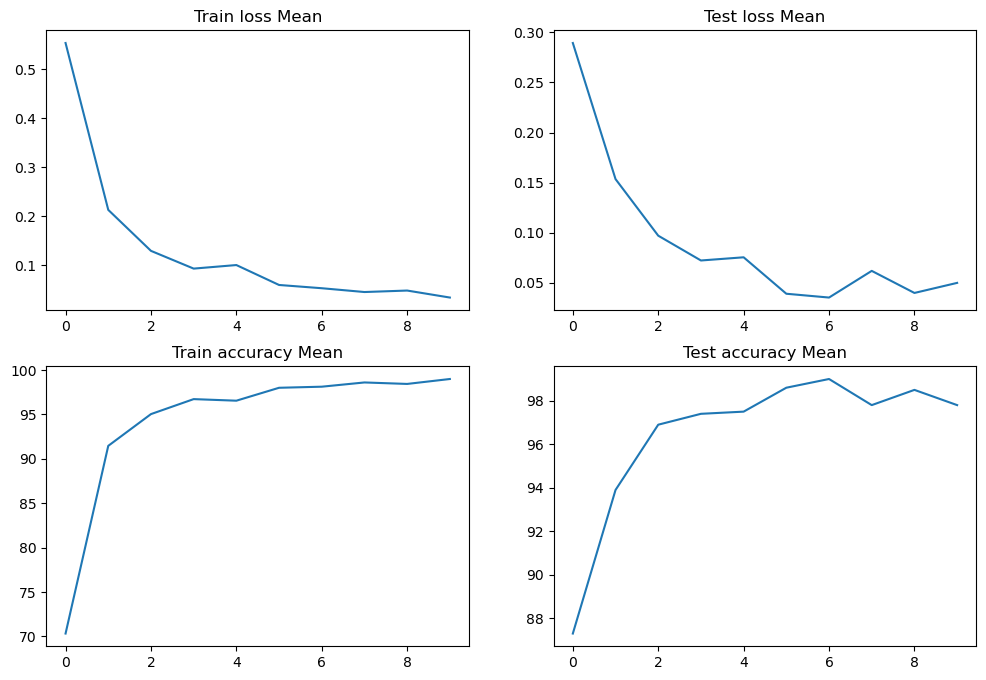

In [9]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title('Train loss Mean')
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title('Test loss Mean')
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title('Train accuracy Mean')
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title('Test accuracy Mean')
plt.plot(all_test_accuracy)

# Loading Best Model

In [10]:
model = C8SteerableCNN(2).to(device)
model.load_state_dict(torch.load('bestmodel.pth'), strict=False)

# Testing

In [11]:
true_label, pred_label, pred_score, one_hot = [], [], [], []
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(tqdm(lense_test)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)

        _, pred = torch.max(_y.data, 1)
        true_label += y.tolist()
        pred_label += pred.tolist()
        pred_score += _y.tolist()
        one_hot += np.eye(3)[y.cpu().numpy()].tolist()

100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


# Confusion Matrix

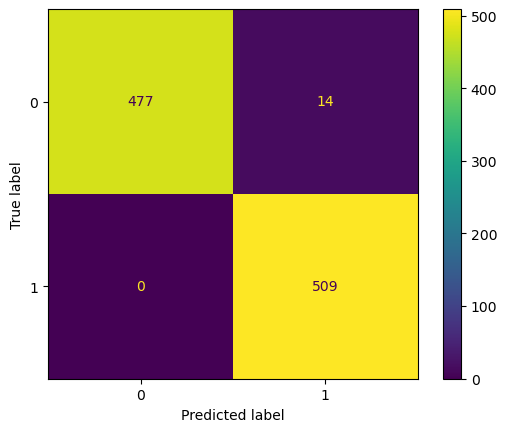

In [12]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(true_label, pred_label)
).plot()

# AUC Score

In [13]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
roc_auc_score(np.array(true_label),np.array(pred_label))

0.9857433808553971

# ROC-CURVE

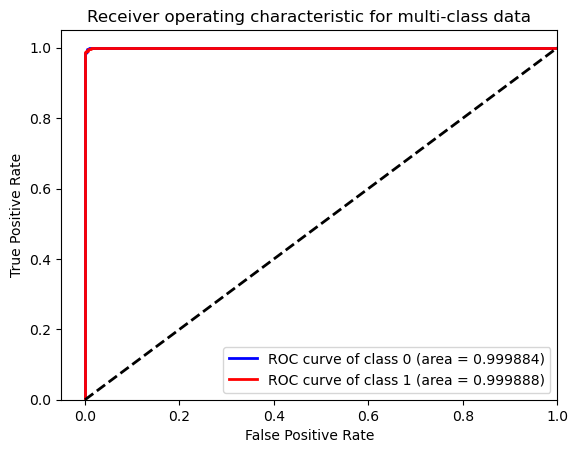

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(one_hot)[:, i], np.array(pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()